Training for efficientnet on cropped image patches

In [1]:
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from PIL import Image, ImageOps
import os
import argparse
import time
import os, sys
from time import strftime
from sklearn.metrics import mean_squared_error, accuracy_score, hamming_loss, roc_curve, auc, f1_score
import copy
from torch.utils.data import DataLoader, Dataset
import random
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.models as models
from torch.autograd import Variable
import torch.nn as nn
import cv2
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf #2.8.3
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from efficientnet.keras import center_crop_and_resize, preprocess_input
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

# pip install efficientnet-python opencv-python tensorflow efficientnet

2022-12-21 05:13:15.529825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 05:13:16.547656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-21 05:13:16.547749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PAT

In [2]:
class data_loader(Sequence):
    """
    Dataset to read image and label for training
    """
    def __init__(self, list_IDs, labels, batch_size=64, dim=(224,224), n_channels=3,
                 n_classes=2, shuffle=False):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.asarray(Image.open(ID))[...,:3]
            # Store class
            y[i] = self.labels[ID]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [3]:
rand_seed = 10709
if rand_seed is not None:
    np.random.seed(rand_seed)
    torch.manual_seed(rand_seed)
    torch.cuda.manual_seed(rand_seed)

use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)

device = torch.device("cuda:0")  

Using GPU:  True


In [4]:
train_pos = r"./crops_med/training_pos" #"C:\Users\emm75\Documents\BMI_771\BMI771_Project\crops_1\training_pos"
train_neg = r"./crops_med/training_neg" #"C:\Users\emm75\Documents\BMI_771\BMI771_Project\crops_1\training_neg"
test_pos = r"./crops_lg_4new/training_pos" #"C:\Users\emm75\Documents\BMI_771\BMI771_Project\crops_1\val_pos"
test_neg = r"./crops_lg_4new/training_neg" #"C:\Users\emm75\Documents\BMI_771\BMI771_Project\crops_1\val_neg"

img_train_pos = [join(train_pos, f) for f in listdir(train_pos) if isfile(join(train_pos, f))]
img_train_neg = [join(train_neg, f) for f in listdir(train_neg) if isfile(join(train_neg, f))]
img_test_pos = [join(test_pos, f) for f in listdir(test_pos) if isfile(join(test_pos, f))]
img_test_neg = [join(test_neg, f) for f in listdir(test_neg) if isfile(join(test_neg, f))]

In [5]:
IMG_SIZE = 224
NUM_CLASSES = 2 
batch = 64

features = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

label_gen = {}
i_pos = img_train_pos + img_test_pos
for i in i_pos:
    label_gen[i] = 1
i_neg = img_train_neg + img_test_neg
for j in (i_neg):
    label_gen[j] = 0

img_gen = {'train': [], 'test': []}
g_pos = img_train_pos + img_train_neg
for k in g_pos:
    img_gen['train'] = img_gen['train'] + [k]
g_neg = img_test_pos + img_test_neg
for l in (g_neg):
    img_gen['test'] = img_gen['test'] + [l]

#print(img_gen['train'])

In [6]:
train_set = data_loader(img_gen['train'], label_gen, **features)
test_set = data_loader(img_gen['test'], label_gen, **features)

In [7]:
layer_train = Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomFlip(mode="vertical"),
    ],
    name = 'layer_train',
)

2022-12-21 05:13:20.480892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 05:13:20.483771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 05:13:20.485484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 05:13:20.487796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [8]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    trained = layer_train(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(trained)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [9]:
epochs = 40

hist = model.fit(train_set, epochs=epochs, validation_data=test_set, verbose=2)

Epoch 1/40


2022-12-21 05:13:26.441445: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2022-12-21 05:13:45.624850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not m

141/141 - 133s - loss: 0.8865 - accuracy: 0.8262 - val_loss: 0.4904 - val_accuracy: 0.8191 - 133s/epoch - 941ms/step
Epoch 2/40
141/141 - 88s - loss: 0.4734 - accuracy: 0.8795 - val_loss: 0.4979 - val_accuracy: 0.8196 - 88s/epoch - 625ms/step
Epoch 3/40
141/141 - 88s - loss: 0.3613 - accuracy: 0.8849 - val_loss: 0.6950 - val_accuracy: 0.8198 - 88s/epoch - 623ms/step
Epoch 4/40
141/141 - 88s - loss: 0.3286 - accuracy: 0.8947 - val_loss: 0.5063 - val_accuracy: 0.8486 - 88s/epoch - 623ms/step
Epoch 5/40
141/141 - 88s - loss: 0.2796 - accuracy: 0.9056 - val_loss: 13.5037 - val_accuracy: 0.8194 - 88s/epoch - 623ms/step
Epoch 6/40
141/141 - 88s - loss: 0.2501 - accuracy: 0.9108 - val_loss: 3.2135 - val_accuracy: 0.8422 - 88s/epoch - 624ms/step
Epoch 7/40
141/141 - 88s - loss: 0.2216 - accuracy: 0.9141 - val_loss: 0.9665 - val_accuracy: 0.8472 - 88s/epoch - 624ms/step
Epoch 8/40
141/141 - 88s - loss: 0.2239 - accuracy: 0.9189 - val_loss: 0.7866 - val_accuracy: 0.6615 - 88s/epoch - 622ms/step


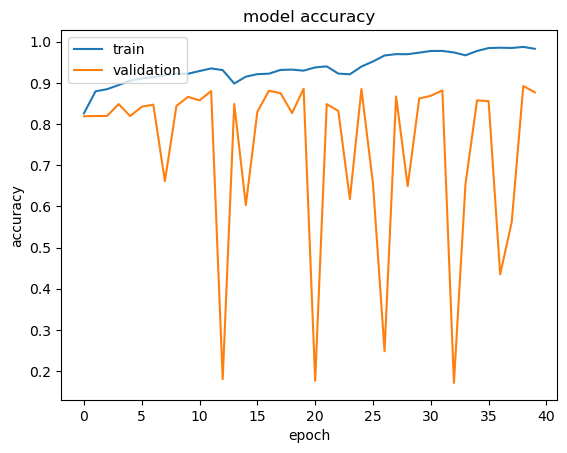

In [10]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig('med3_4test_40ep_accuracy.pdf')
    plt.show()

plot_hist(hist)

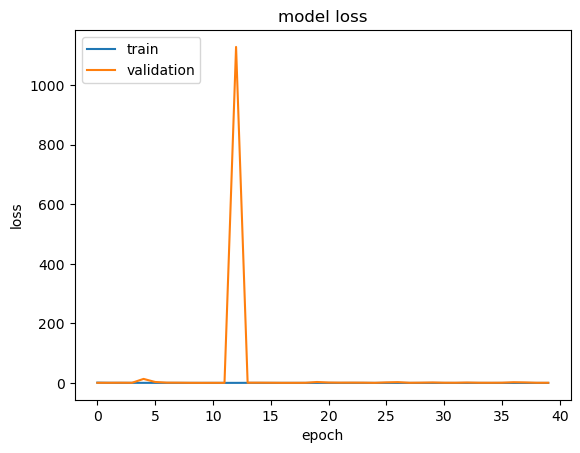

In [11]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig('med3_4test_40ep_loss.pdf')
    plt.show()

plot_hist(hist)

In [12]:
hist.history

{'loss': [0.8865013122558594,
  0.47336193919181824,
  0.3612790107727051,
  0.3285582661628723,
  0.27964869141578674,
  0.25007468461990356,
  0.22159969806671143,
  0.2238711714744568,
  0.21680046617984772,
  0.20760202407836914,
  0.20351098477840424,
  0.1825307011604309,
  0.21819134056568146,
  0.29276522994041443,
  0.22594453394412994,
  0.21578791737556458,
  0.23050931096076965,
  0.1943022608757019,
  0.1945793181657791,
  0.18625067174434662,
  0.18295539915561676,
  0.17181745171546936,
  0.24044235050678253,
  0.21167343854904175,
  0.16475418210029602,
  0.1348390281200409,
  0.10225403308868408,
  0.08921054750680923,
  0.09068331867456436,
  0.08162079751491547,
  0.06798029690980911,
  0.06873947381973267,
  0.08909007906913757,
  0.09603580832481384,
  0.06668664515018463,
  0.04839327931404114,
  0.045794777572155,
  0.047417543828487396,
  0.03562106937170029,
  0.0490279495716095],
 'accuracy': [0.826241135597229,
  0.8795434236526489,
  0.8848626017570496,
  0.

In [22]:
# pred_pos = r"./crops_med/val_pos" 
# pred_neg = r"./crops_med/val_neg" 
pred_pos = r"./new_c8/val_pos"
pred_neg = r"./new_c8/val_neg"

img_pred_pos = [join(pred_pos, f) for f in listdir(pred_pos) if isfile(join(pred_pos, f))]
img_pred_neg = [join(pred_neg, f) for f in listdir(pred_neg) if isfile(join(pred_neg, f))]

pred_features = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': False}

lab_gen = {}
pred_gen = {'predict': []}
for i in img_pred_pos:
    lab_gen[i] = 1 
    pred_gen['predict'] = pred_gen['predict'] + [i]
for j in (img_pred_neg):
    lab_gen[j] = 0
    pred_gen['predict'] = pred_gen['predict'] + [j]

pred_set = data_loader(pred_gen['predict'], lab_gen, **pred_features)
len(img_pred_neg)

462

In [23]:
loss_acc = model.evaluate(pred_set)
np.save("med3_4test_40ep_c8_loss_acc",loss_acc)
loss_acc

2022-12-21 06:16:56.374734: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:759"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



15/15 [==============================] - 3s 182ms/step - loss: 1.5549 - accuracy: 0.6333


[1.5548994541168213, 0.6333333253860474]

In [24]:
matrix = model.predict(pred_set)

2022-12-21 06:17:20.494715: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:775"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



15/15 [==============================] - 3s 186ms/step


In [25]:
import math

# height = 77884 
# width = 140765
# s = 2095
# dx = 64 
# dy = 34

height = 56013 
width = 75208
s = 2137 
dx = int(int(width)/int(s)) #dx = math.ceil(int(width)/int(s)) 
dy = int(int(height)/int(s)) #dy = math.ceil(int(height)/int(s)) 

print(dx,dy)

mlist0 = matrix[:,0].tolist()
mlist1 = matrix[:,1].tolist()

#x = int(math.sqrt(len(mlist)))

marray0 = []
marray1 = []
count = 0
for i in range(dy):
    marray0.append(mlist0[count:count+(dx)])
    marray1.append(mlist1[count:count+(dx)])
    count += (dx)
marray0

35 26


[[0.3746407628059387,
  0.06564074009656906,
  0.0270641278475523,
  0.9950410723686218,
  0.023472541943192482,
  0.9939579963684082,
  0.999996542930603,
  0.6497758626937866,
  0.900763988494873,
  0.19904828071594238,
  0.9566311836242676,
  0.04774771258234978,
  0.38102057576179504,
  0.8751862645149231,
  0.8702270984649658,
  0.9263462424278259,
  0.3185369372367859,
  0.9018718004226685,
  0.9981932044029236,
  0.9690478444099426,
  0.011782972142100334,
  0.002311735413968563,
  0.04503551498055458,
  0.8374369144439697,
  0.0004558014334179461,
  0.16653332114219666,
  0.9900744557380676,
  0.0007254778174683452,
  0.5049183964729309,
  0.7157920598983765,
  0.9977717995643616,
  0.8384621739387512,
  0.9771856069564819,
  0.04809931293129921,
  0.02165883779525757],
 [0.5749146342277527,
  0.9926364421844482,
  0.7524152398109436,
  0.9498685002326965,
  0.9916791319847107,
  0.1586814969778061,
  0.9991286396980286,
  0.002044542459771037,
  0.995528519153595,
  0.96887177

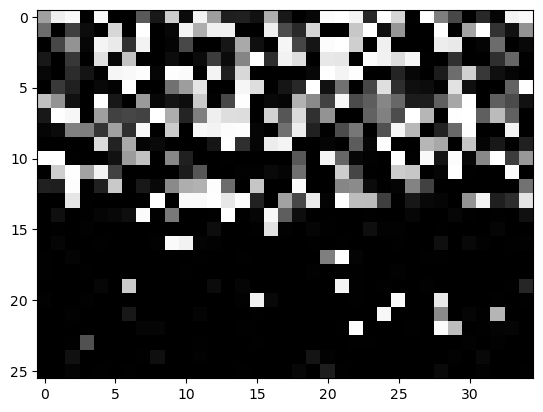

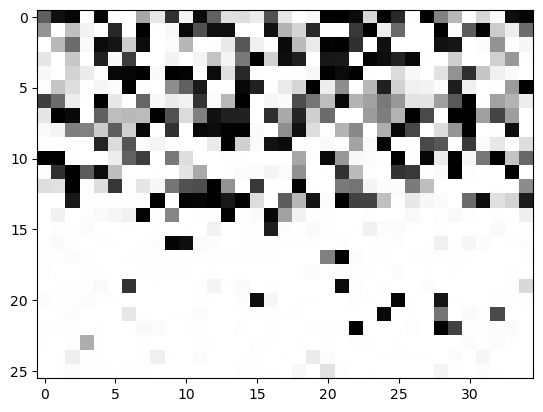

In [26]:
plt.imshow(np.array(marray0), cmap='binary', interpolation=None)
plt.savefig('med3_4test_40ep_c8_prediction0.pdf')
plt.show()

plt.imshow(np.array(marray1), cmap='binary', interpolation=None)
plt.savefig('med3_4test_40ep_c8_prediction1.pdf')
plt.show()

In [27]:
print(type(matrix))
np.save("med3_4test_c8_40ep",matrix)
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

<class 'numpy.ndarray'>
